#

In [3]:
import sys
scripts = 'scripts'
import glob
sys.path.append(scripts)
import BLASTanalysis
import os
import importlib
import pandas as pd
blastdb = 'Database/viral_mRNA.fasta'
resultsDir = 'Results'
if not os.path.isdir(resultsDir):
    os.mkdir(resultsDir)
#blast variables for identifying junctions
percentIdentity = 90
wordSize = 10
gapOpen = 5
gapExtend = 2
eValue = 0.000001
outFormat = '"6 qseqid qlen qstart qend sstart send evalue sseqid qseq"'
Tenxsegments = ['PB2_mRNA','PB1_mRNA','PA_mRNA',  'HA_mRNA','NP_mRNA','NA_mRNA','M_mRNA','NS_mRNA']

#multiprocessing for mapping to speed things up a bit
from multiprocessing import Pool
numProcessors = 4
import subprocess
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams.update({'font.size': 12, 'axes.titlesize':'medium',})

In [4]:
os.system('samtools view -H 1905NSmut/outs/possorted_genome_bam.bam > temp.sam')
for segment in Tenxsegments:
    os.system('samtools view 1905NSmut/outs/possorted_genome_bam.bam ' + segment + ' | awk \'($6 ~ /N/)\' >> temp.sam')
      

!samtools fasta temp.sam > temp.fa
outfile = 'Results/deletionJunctions.blastout'
infile = 'temp.fa'
arguments = ' '.join(['-db', blastdb, '-query', infile, '-perc_identity', str(percentIdentity), 
                     '-num_threads', str(numProcessors), '-word_size', str(wordSize), '-gapopen', str(gapOpen),
                     '-gapextend', str(gapExtend), '-evalue', str(eValue), '-outfmt', outFormat,
                     '-out', outfile])
!blastn $arguments

BLASTanalysis.delAnnotate('Results/deletionJunctions_1905NSmut.blastout', 'Results/deletionJunctions_junctions_1905NSmut.tsv', 'Database/viral_mRNA.fasta')


BLASTanalysis.delAssign('temp.sam', 'Results/deletionJunctions_junctions_1905NSmut.tsv','Results/deletionJunctions_junctions_barcodes_1905NSmut.tsv')
!rm -f temp.sam
!rm -f temp.fa


[M::bam2fq_mainloop] discarded 0 singletons
[M::bam2fq_mainloop] processed 0 reads


[E::hts_open_format] Failed to open file 1905NSmut/outs/possorted_genome_bam.bam
samtools view: failed to open "1905NSmut/outs/possorted_genome_bam.bam" for reading: No such file or directory
[E::hts_open_format] Failed to open file 1905NSmut/outs/possorted_genome_bam.bam
samtools view: failed to open "1905NSmut/outs/possorted_genome_bam.bam" for reading: No such file or directory
[E::hts_open_format] Failed to open file 1905NSmut/outs/possorted_genome_bam.bam
samtools view: failed to open "1905NSmut/outs/possorted_genome_bam.bam" for reading: No such file or directory
[E::hts_open_format] Failed to open file 1905NSmut/outs/possorted_genome_bam.bam
samtools view: failed to open "1905NSmut/outs/possorted_genome_bam.bam" for reading: No such file or directory
[E::hts_open_format] Failed to open file 1905NSmut/outs/possorted_genome_bam.bam
samtools view: failed to open "1905NSmut/outs/possorted_genome_bam.bam" for reading: No such file or directory
[E::hts_open_format] Failed to open file

KeyboardInterrupt: 

In [5]:
mSplices = [(56,745), (48,745), (666,745)]
NSsplices = [(57,530)]
deletions = pd.read_csv('Results/deletionJunctions_junctions_barcodes_1905NSmut.tsv', encoding='utf8' , sep='\t')
for splice in mSplices:
    deletions = deletions.loc[~((deletions.segment == 'M_mRNA') & (deletions.fiveprime == splice[0]) & (
                                    deletions.threeprime == splice[1]))]
for splice in NSsplices:
    deletions = deletions.loc[~((deletions.segment == 'NS_mRNA') & (deletions.fiveprime == splice[0]) & (
                                    deletions.threeprime == splice[1]))]
deletions = deletions[['barcode', 'segment', 'fiveprime','threeprime', 'count']]
deletions.to_csv('Results/deletionJunctions_junctions_barcodes_1905NSmut.tsv', sep='\t')

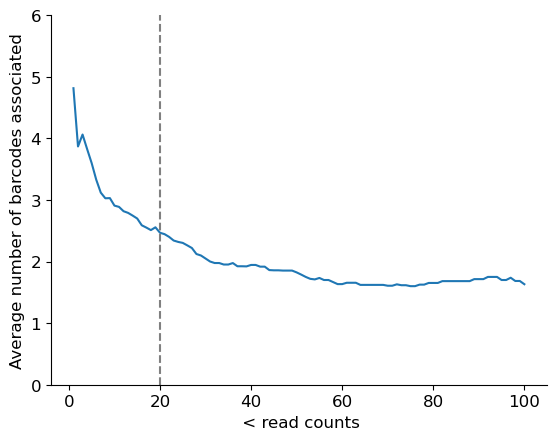

In [6]:
currNum = 1
finalNum = 100
graph = [] 
while currNum <= finalNum:
    mean = deletions[deletions['count'] >= currNum].groupby([ 'segment', 'fiveprime', 'threeprime']).count().reset_index()['count'].mean()
    currData = pd.DataFrame({'read_counts':[currNum], 'average emulsions':[mean]})
    graph += [currData]
    currNum += 1
graph=pd.concat(graph)
ax = sns.lineplot(data=graph, x="read_counts", y="average emulsions")
sns.despine()
plt.xlabel(' < read counts')
plt.ylabel('Average number of barcodes associated')
plt.axvline(x=20, c='0.5', linestyle='--')
plt.ylim(0,6)
plt.savefig('Figures/delThresh1905mut.pdf')

In [7]:
deletions = deletions[deletions['count'] >= 20]
deletions = deletions.dropna()
prefix = 'human_flu_'
deletions = BLASTanalysis.adjReads('', deletions, '1905NSmut/outs/possorted_genome_bam.bam')
deletions.to_csv('Results/curatedDeletions_1905NSmut.tsv', sep='\t')